In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
from scipy.interpolate import NearestNDInterpolator
from scipy.optimize import curve_fit 
import scipy.integrate as integrate
import scipy.special as special
from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D







from collections import OrderedDict


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
#absorp_tab = Table.read('../3D_CMZ/LBV_plots_stuff/absorption_table_merged.tex')
starcount_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/starcounts_tab.tex")


cat_index = tab['leaf_id']
cloud_name = tab['cloud_name']
corr_coeff = tab['corr_coeff']
flux_diff = tab['flux_diff']
fdiff_stdv = tab['flux_diff_stdv']
flux_ratio = tab['flux_ratio']
fratio_stdv = tab['flux_ratio_stdv']
absorp_value = tab['absorp_value']
starcount_ratio = starcount_tab['counts_ratio_from_avg']
starcount_ratio_stdv = starcount_tab['counts_ratio_stdv']


In [4]:
starcount_tab[-1]

cloud_index,cloud_name,cloud_avg_count,model_avg_count,cloud_min_count,model_min_count,counts_ratio_from_avg,cloud_stddv,model_stddv,counts_ratio_stdv
str3,str14,float64,float64,float64,float64,float64,float64,float64,float64
31,G1.652-0.052,7.883257318273943,2.9546837808108206,3.039776955371629,2.7666809790385405,2.668054486734492,2.1155205605105807,0.09570001972556319,0.2703036918286295


In [20]:
tab[18]

leaf_id,cloud_name,l,b,v,sigma,rad,corr_coeff,flux_diff,flux_diff_stdv,flux_ratio,flux_ratio_stdv,absorp_value,NF_decision,absorp_NF,lb_pixel_mask
str3,str14,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,str3,str3,int64
12,G0.035+0.032,0.035,0.032,86,7,2.7,-0.28,-156.53,225.69,0.86,0.5,3.87,F,nan,1


In [25]:
z_norming(flux_ratio[18], 0, 1)

0.72

In [37]:
fratio_stdv_normed[18], fratio_cn

(-0.0, 0.0)

In [6]:
print(np.nanmax(flux_diff), np.nanmin(flux_diff))
print(np.nanmax(flux_ratio), np.nanmin(flux_ratio))

74.09 -177.87
0.92 -0.8


In [39]:
def z_norming(i, min_value, max_value):
    z_i = 2. * ((i - min_value) / (max_value - min_value)) - 1.
    return z_i

# normalize the data value between -1 and 1 for the 
# flux difference list 
# but need to center it on -108
#fdiff_cn = z_norming(-108, np.nanmin(flux_diff), np.nanmax(flux_diff))
fdiff_cn = z_norming(-108, -150, 150)

fdiff_stdv_centered = fdiff_stdv 

# flux ratio is centered on 0.5
#fratio_cn = z_norming(0.5, np.nanmin(flux_ratio), np.nanmax(flux_ratio))
fratio_cn = z_norming(0.5, 0., 1.)
fratio_stdv_centered = (fratio_stdv)

# Absorption centered on 1.
absorp_cn = z_norming(1., np.nanmin(absorp_value), 3.5)


# Star Count ratio centered on 1, min 0 and max 2
countratio_cn = z_norming(1., 0, 2)




flux_ratio_normed = []
flux_diff_normed = []
fdiff_stdv_normed = []
fratio_stdv_normed = []
absorp_normed = []
starcounts_normed = []
starcounts_stdv_normed = []


for i in range(len(cat_index)):
    
    ###FDIFF NORMING 
    z_fdiff_i = z_norming(flux_diff[i], np.nanmin(flux_diff), np.nanmax(flux_diff))
    flux_diff_normed.append(z_fdiff_i-fdiff_cn) 
    
    z_fdiff_stdv_i = z_norming(fdiff_stdv_centered[i], np.nanmin(flux_diff), np.nanmax(flux_diff))
    fdiff_stdv_normed.append(z_fdiff_stdv_i)
    
    ###FRATIO NORMING 
    #z_i = z_norming(flux_ratio[i], np.nanmin(flux_ratio), np.nanmax(flux_ratio))
    z_i = z_norming(flux_ratio[i], 0, 1)
    flux_ratio_normed.append(-(z_i-fratio_cn)) 
    
    #z_fratio_stdv_i = z_norming(fratio_stdv_centered[i], np.nanmin(flux_ratio), np.nanmax(flux_ratio))
    z_fratio_stdv_i = z_norming(fratio_stdv_centered[i], 0, 1)
    if i == 18:
        fratio_stdv_normed.append(-(0.5)) #ID 12 is weird
    else:
        fratio_stdv_normed.append(-(z_fratio_stdv_i))
    
    ###ABSORP NORMING 
    if np.isnan(absorp_value[i]) == False:
        z_i_absorp = z_norming(absorp_value[i], np.nanmin(absorp_value), 3.5)
        absorp_normed.append(-(z_i_absorp-absorp_cn))
    if np.isnan(absorp_value[i]) == True:
        absorp_normed.append(np.nan)
        
    ###STARCOUNTS NORMING
    z_countratio_i = z_norming(starcount_ratio[i], 0, 2)
    starcounts_normed.append(-(z_countratio_i-countratio_cn) )
    
    z_countratio_stdv_i =  z_norming(starcount_ratio_stdv[i], 0, 2)
    starcounts_stdv_normed.append(z_countratio_stdv_i) 
    
        


In [40]:
def corr_coeff_gauss_dist(x, mu):
    if np.isnan(mu)==True:
        return x*np.nan

    if (mu < 0) or (mu > 0.3):
        sigma = np.nanstd(corr_coeff)
    if (mu < 0.3) & (mu >= 0):
        sigma = np.nanstd(3.*corr_coeff)
    
    #factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return   exp 


def flux_diff_gauss_dist(x, mu, sigma):
    sigma=abs(sigma)
    #factor = 1./( sigma * np.sqrt(2.*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
    return    exp 



def flux_ratio_gauss_dist(x, mu, sigma):
    sigma=abs(sigma)  
    #factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return      exp 


def absorp_gauss_dist(x, mu):
    sigma = np.nanstd(absorp_normed, where=np.array(absorp_value)<3.5)     
    #factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return     exp 

def starcount_gauss_dist(x, mu, sigma):
    sigma=abs(sigma)  
    #factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return      exp 


def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2.* (sigma**2 )))

In [49]:
x = np.arange(-20,20, 0.01)


class ppdf:
        
    def __init__(self, cloud_id):
        x = np.arange(-20,20, 0.01)

        cat_id = np.where(cat_index == cloud_id)[0][0]

        if np.isnan(corr_coeff[cat_id])==False:
            r_dist = corr_coeff_gauss_dist(x, corr_coeff[cat_id]) 
            r_norm = integrate.quad(corr_coeff_gauss_dist, -np.inf, np.inf, args=(corr_coeff[cat_id]))[0]
            r_dist      /=  r_norm 
            self.corr_coeff = r_dist 

        if np.isnan(absorp_normed[cat_id])==False:
            absorp_dist = absorp_gauss_dist(x, absorp_normed[cat_id])
            absorp_norm = integrate.quad(absorp_gauss_dist, -np.inf, np.inf, args=(absorp_normed[cat_id]))[0]
            absorp_dist /=  absorp_norm
            self.absorp = absorp_dist 


        fratio_dist = flux_ratio_gauss_dist(x, flux_ratio_normed[cat_id],fratio_stdv_normed[cat_id])
        fratio_norm = integrate.quad(flux_ratio_gauss_dist, -np.inf, np.inf, args=(flux_ratio_normed[cat_id],fratio_stdv_normed[cat_id]))[0]
        fratio_dist /=  fratio_norm 
        self.fratio = fratio_dist


        fdiff_dist = flux_diff_gauss_dist(x, flux_diff_normed[cat_id],fdiff_stdv_normed[cat_id] )    
        fdiff_norm = integrate.quad(flux_diff_gauss_dist, -np.inf,np.inf, args=(flux_diff_normed[cat_id],fdiff_stdv_normed[cat_id]))[0]
        fdiff_dist  /=  fdiff_norm
        self.fdiff = fdiff_dist

        starcount_dist = starcount_gauss_dist(x, starcounts_normed[cat_id],starcounts_stdv_normed[cat_id] )    
        starcount_norm = integrate.quad(starcount_gauss_dist, -np.inf,np.inf, args=(starcounts_normed[cat_id],starcounts_stdv_normed[cat_id]))[0]
        starcount_dist  /=  starcount_norm
        self.starcount = starcount_dist

        ### Calculate the posterior PDF
        
        total_pdf = np.empty(np.shape(x))
        total_pdf[:] = 1.
        
        self_dict = vars(self)
        for i in self_dict.items():
            #total_pdf *= i[1]

            if i[0]=='corr_coeff': i_weighted = i[1]*(1./3.)
            if i[0]=='absorp': i_weighted = i[1]*(1./3.)
            if i[0]=='fratio': i_weighted = i[1]*(1./9.)
            if i[0]=='fdiff': i_weighted = i[1]*(1./9.)
            if i[0]=='starcounts': i_weighted = i[1]*(1./9.)

            total_pdf *= i_weighted

        total_norm  = integrate.trapezoid(total_pdf, x)
        total_pdf /= total_norm 
        self.posterior = total_pdf
        
        

                
        

def plotting_color_label(key):
    if key == 'corr_coeff': return 'blue'
    if key == 'absorp': return 'red'
    if key == 'fratio': return 'green'
    if key == 'fdiff': return 'orange'
    if key == 'starcount': return 'gold'
    if key == 'posterior': return 'black'

def plotting_linestyles(key):
    if key == 'corr_coeff': return '--'
    if key == 'absorp': return '-'
    if key == 'fratio': return '-.'
    if key == 'fdiff': return '--'
    if key == 'starcount': return '--'
    if key == 'posterior': return '-'
    

def plot_pdf(cloud_id, pdfvar):
    
    pdfvec = vars(pdfvar)
    cat_id = np.where(cat_index == cloud_id)[0][0]
    
    ###Plot the stuff 
    fig, ax = plt.subplots(1, 1)
    for i in pdfvec.items():
        ax.plot(x, i[1], label = '{}'.format(i[0]), linestyle=plotting_linestyles(i[0]), color=plotting_color_label(i[0]) )



    ax.set_xlabel('Near vs Far Distinction', fontsize= 13, labelpad=30)
    ax.set_ylabel('Relative Probability',fontsize= 13)

    ax.grid(axis='y')

    #ax.set_ylim(0,1.1)
    ax.set_xlim(-1,1)
    ax.text(.95, .95, 'ID: {}'.format(cat_index[cat_id]), fontsize=13, ha='right', va='top', 
            transform=ax.transAxes)

    ax.text(-0.01, -.08, 'FAR', fontsize=13, ha='left', va='top', 
            transform=ax.transAxes)
    ax.text(0.915, -.08, 'NEAR', fontsize=13, ha='left', va='top', 
            transform=ax.transAxes)

    ax.legend(loc=2)
        
    return
    

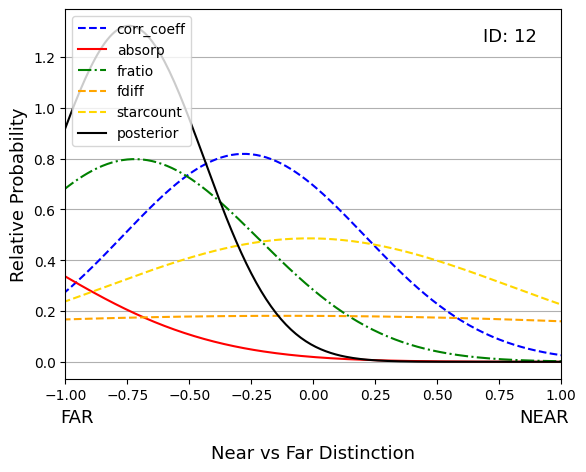

In [74]:
cloudd = '12'
pdfvec=ppdf(cloudd)
plot_pdf(cloudd,pdfvec)

In [ ]:
popt, pcov = curve_fit(gauss_function, x, y, p0 = [1, mean, sigma])


In [79]:
parameters, covariance = curve_fit(gaussian, x, pdfvec.posterior, p0 = [1, np.nanmean(pdfvec.posterior),
                                                                        np.std(pdfvec.posterior)])
parameters

array([ 1.32268414, -0.74287977, -0.30161568])

In [77]:
print(pdfvec.absorp)
print(pdfvec.fratio)
print(pdfvec.fdiff)
print(max(pdfvec.posterior))

[4.55223672e-173 7.02153207e-173 1.08276942e-172 ... 5.88631415e-243
 3.52016501e-243 2.10464891e-243]
[9.9e-324 2.5e-323 4.9e-323 ... 0.0e+000 0.0e+000 0.0e+000]
[3.66351530e-19 3.81668098e-19 3.97616837e-19 ... 1.66741907e-19
 1.59984133e-19 1.53497079e-19]
1.3226238499377292


In [52]:
vars(pdfvec)

{'corr_coeff': array([0., 0., 0., ..., 0., 0., 0.]),
 'absorp': array([4.55223672e-173, 7.02153207e-173, 1.08276942e-172, ...,
        5.88631415e-243, 3.52016501e-243, 2.10464891e-243]),
 'fratio': array([9.9e-324, 2.5e-323, 4.9e-323, ..., 0.0e+000, 0.0e+000, 0.0e+000]),
 'fdiff': array([3.66351530e-19, 3.81668098e-19, 3.97616837e-19, ...,
        1.66741907e-19, 1.59984133e-19, 1.53497079e-19]),
 'starcount': array([1.07114522e-129, 1.44075560e-129, 1.93761656e-129, ...,
        8.84043073e-130, 6.57090663e-130, 4.88329230e-130]),
 'posterior': array([0., 0., 0., ..., 0., 0., 0.])}

In [53]:
parameters, covariance = curve_fit(gaussian, x, pdfvec.posterior)

In [73]:
parameters

array([1.55399717, 0.68031379, 0.25672008])

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_1115/1822430178.py:11: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, covariance =curve_fit(gaussian, x, pdfvec.posterior,
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_1115/1266444902.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_1115/1266444902.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  fratio_norm = integrate.quad(flux_ratio_gauss_dist, -np.inf, np.inf, args=(flux_ratio_normed[cat_id],frati

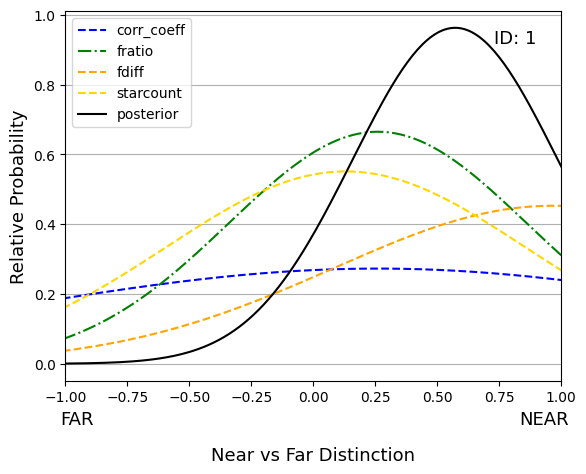

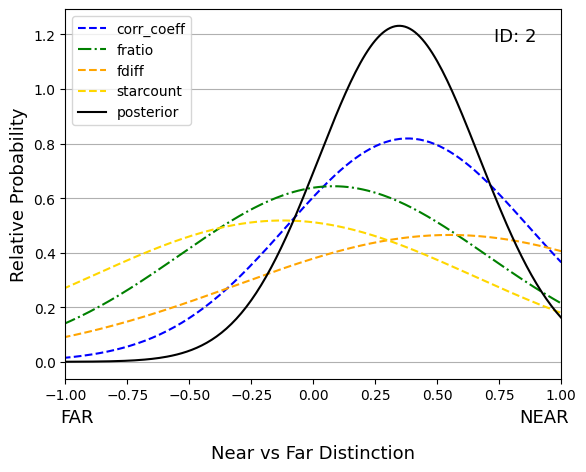

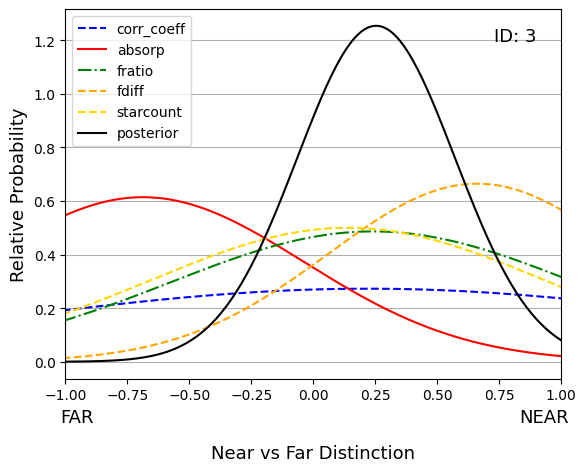

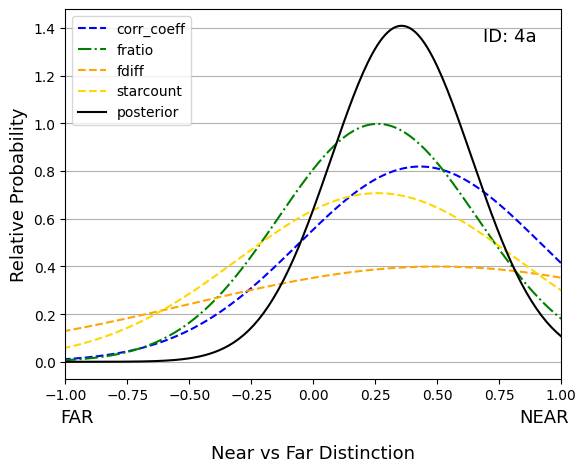

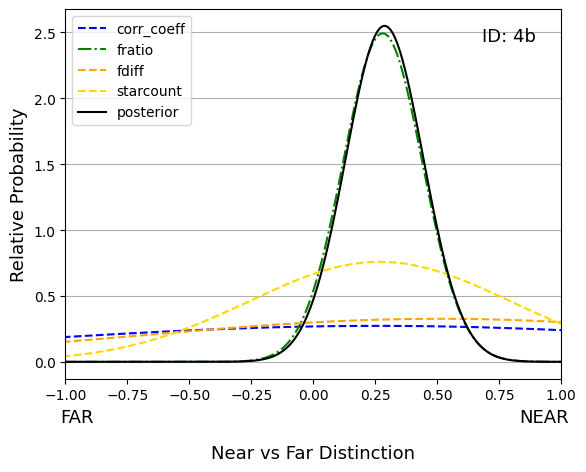

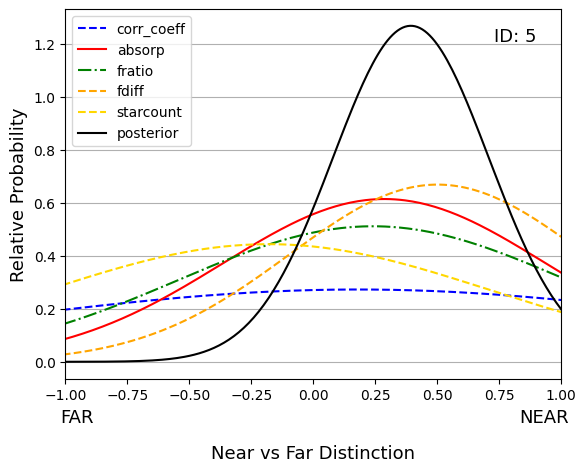

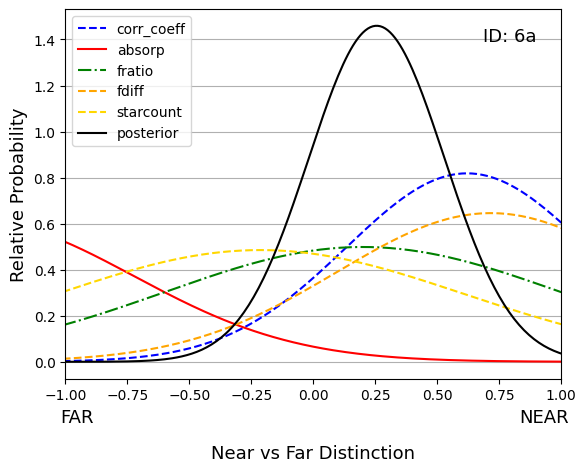

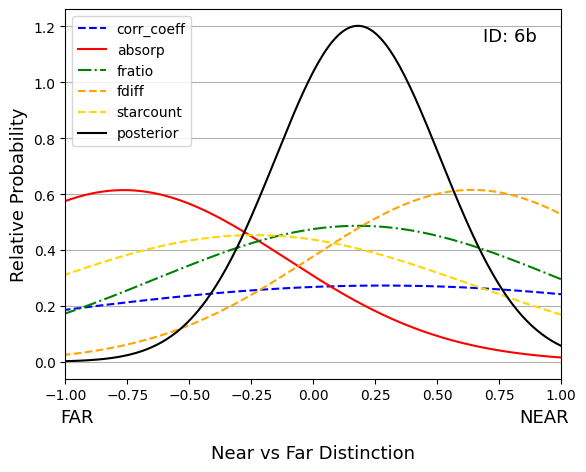

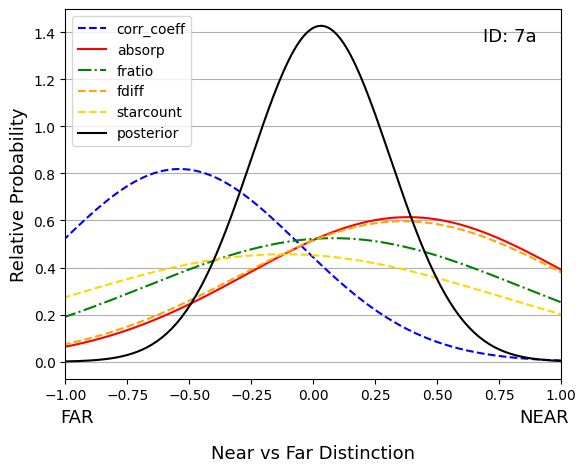

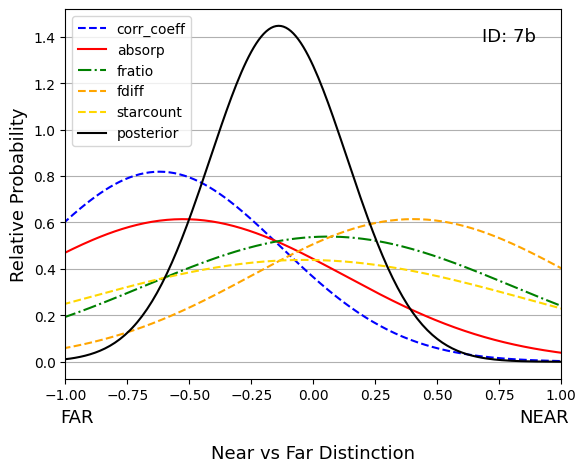

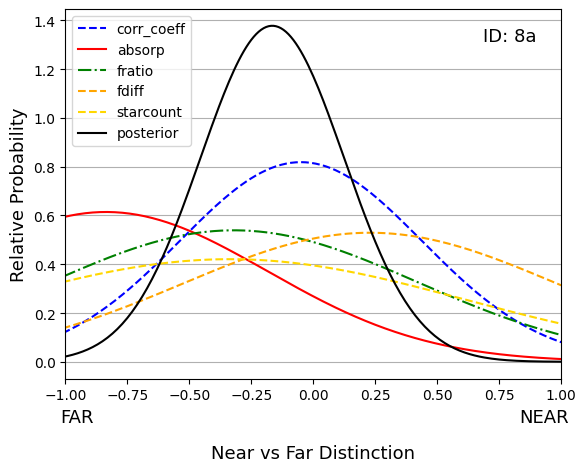

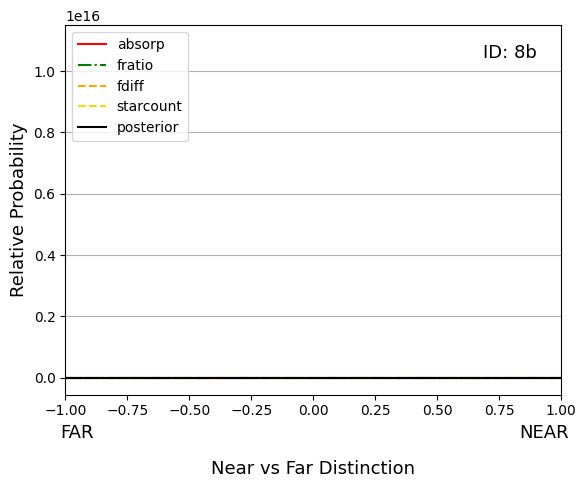

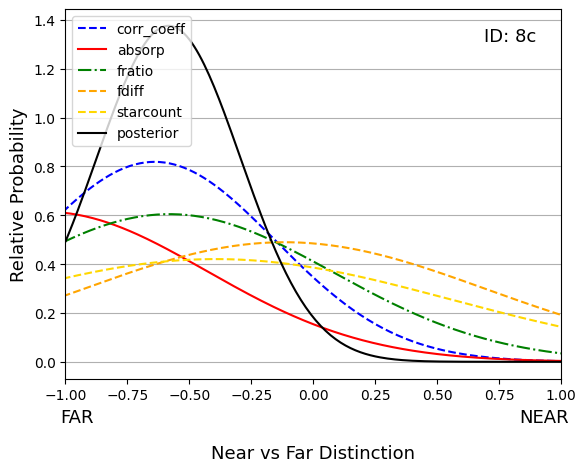

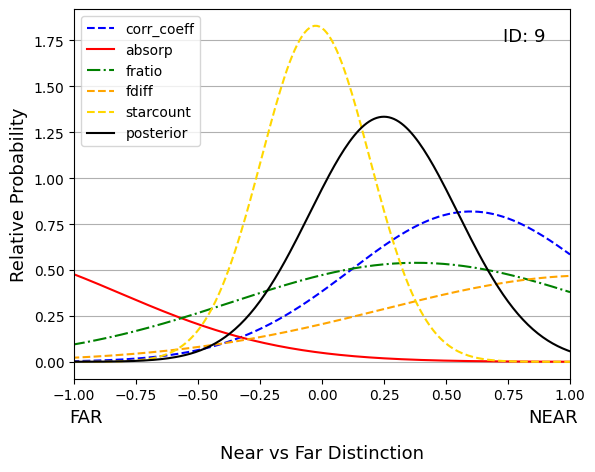

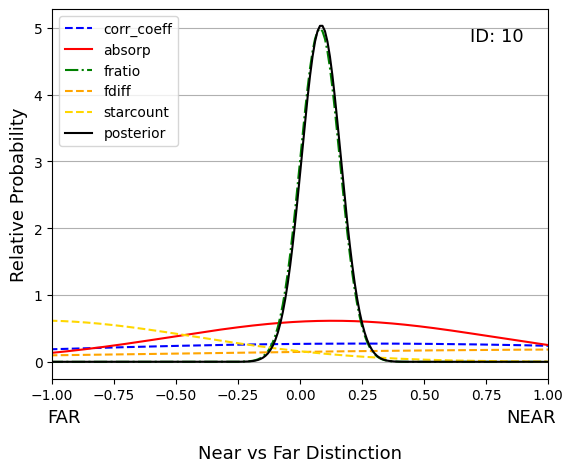

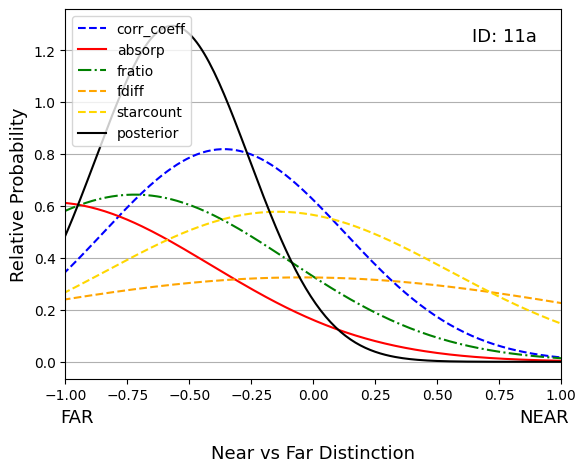

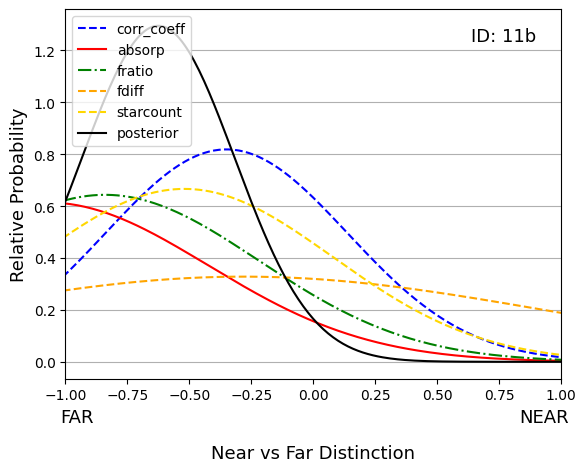

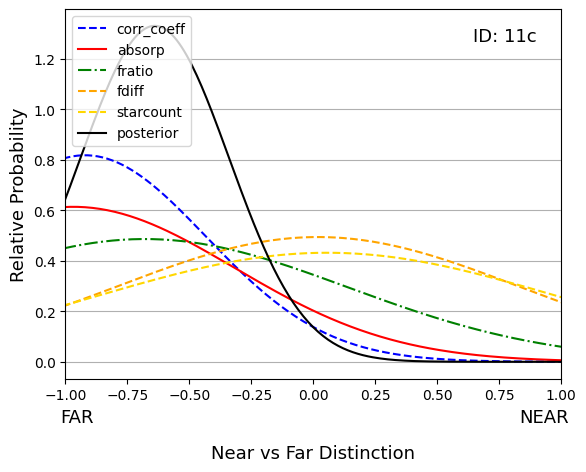

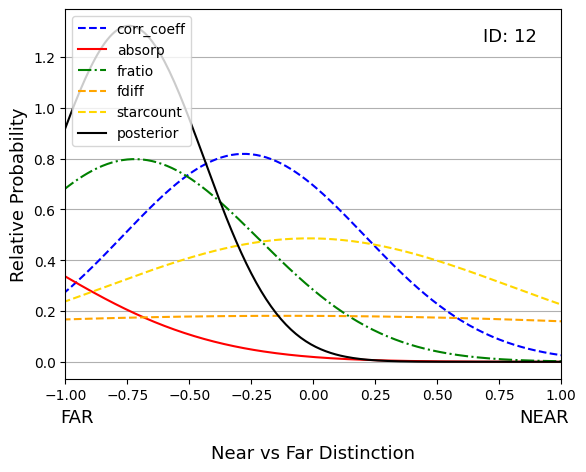

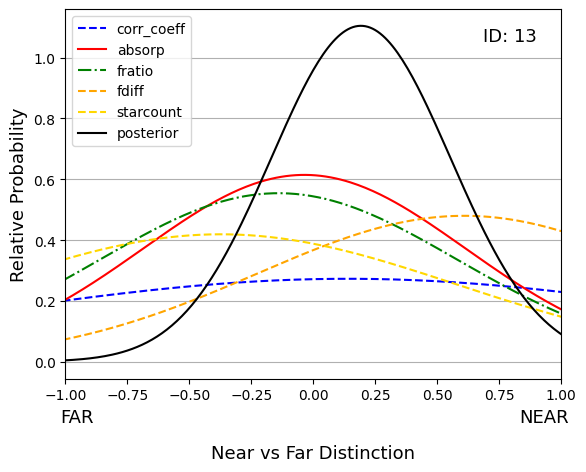

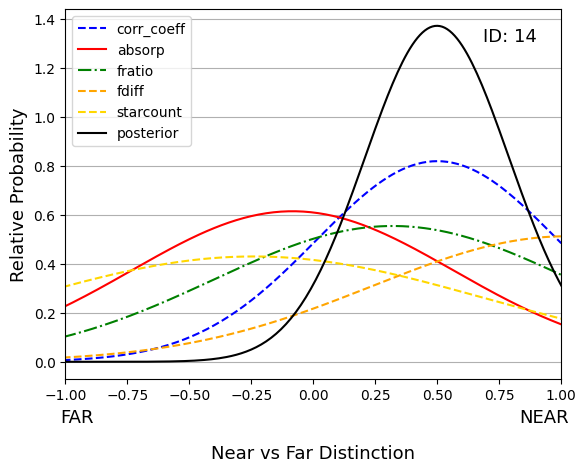

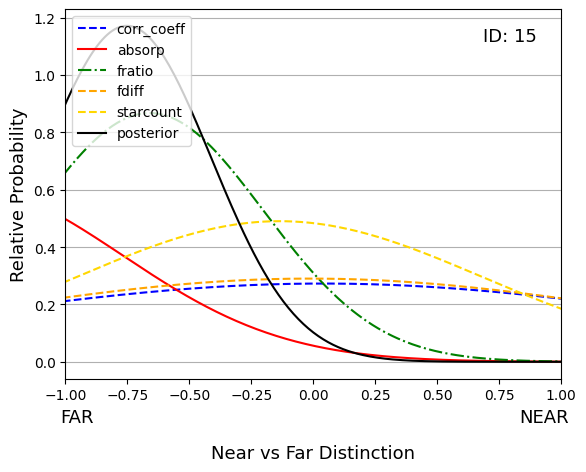

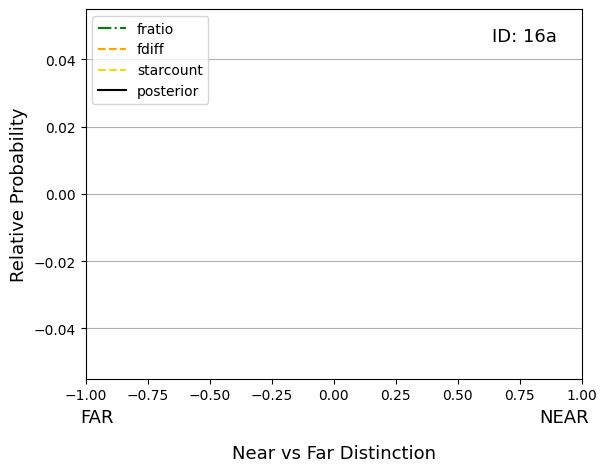

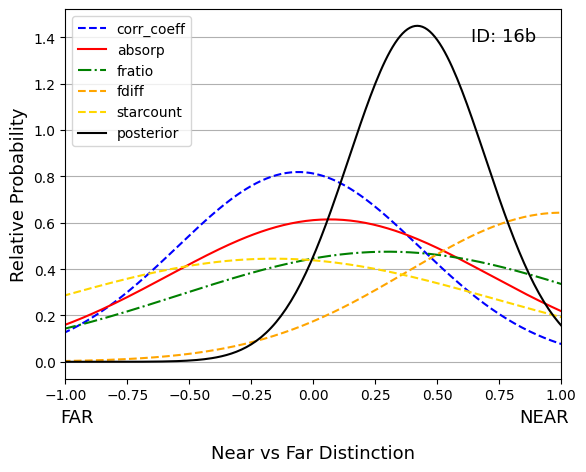

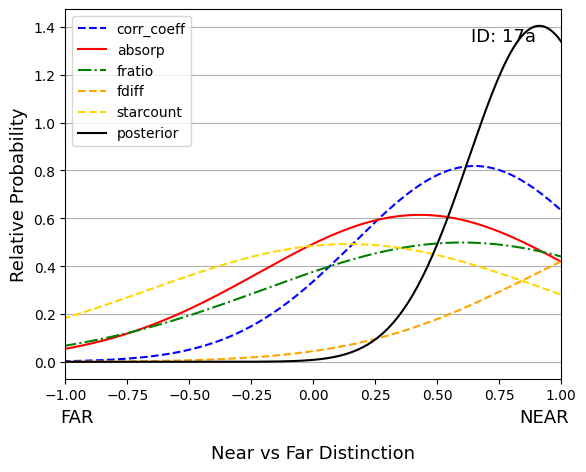

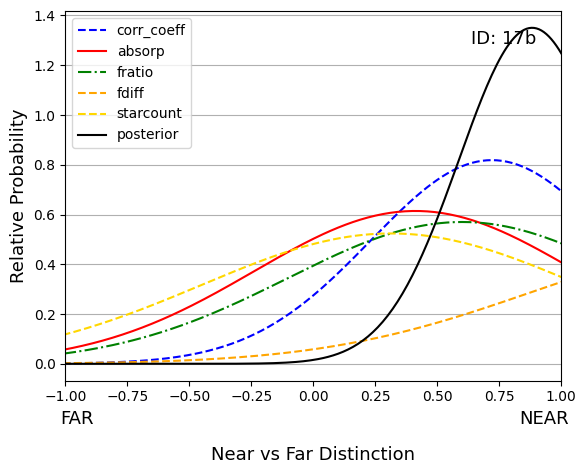

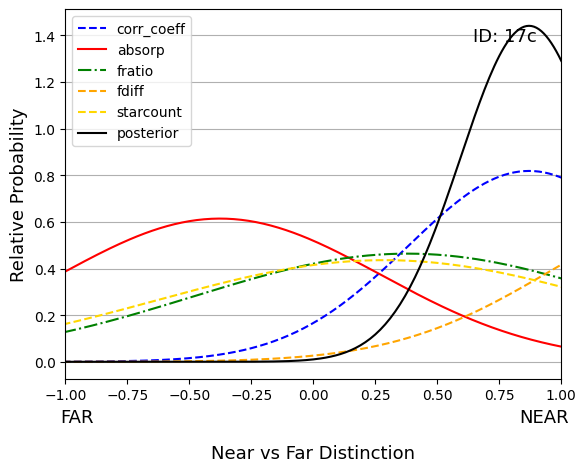

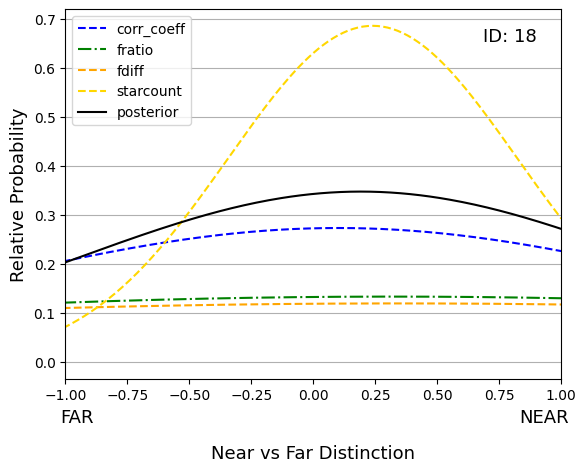

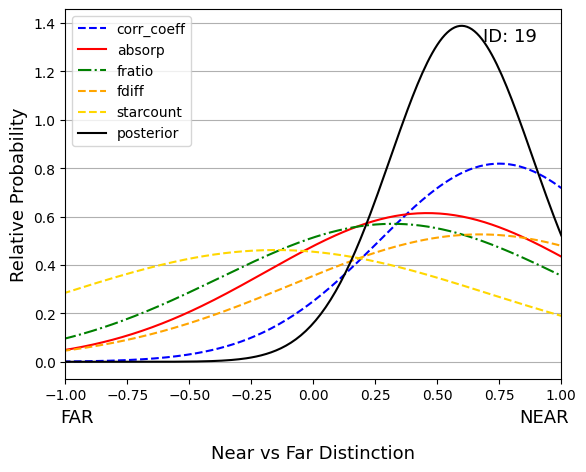

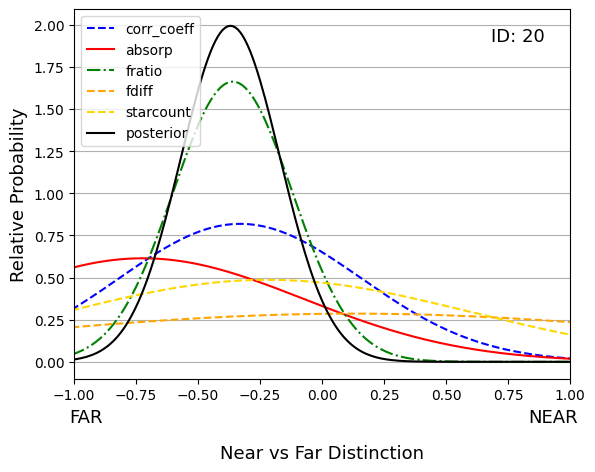

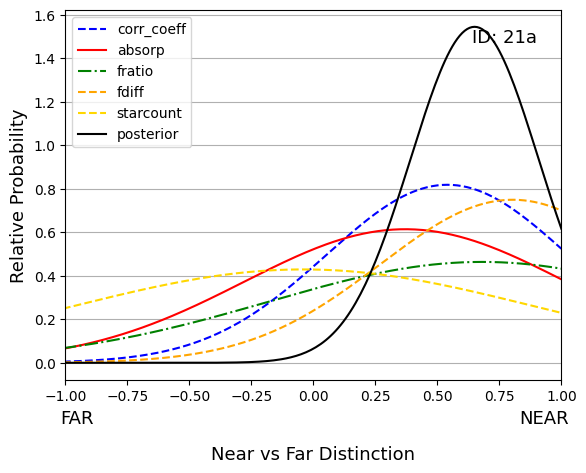

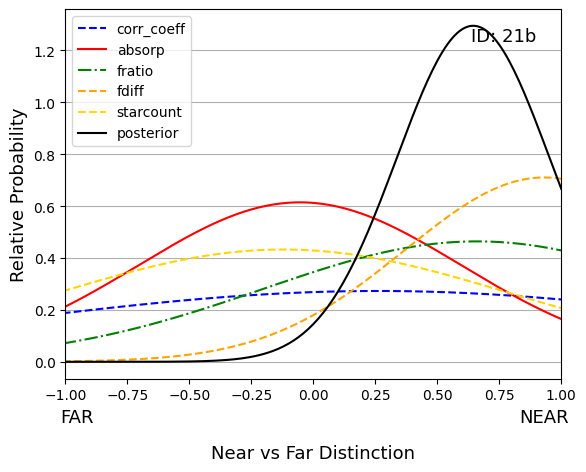

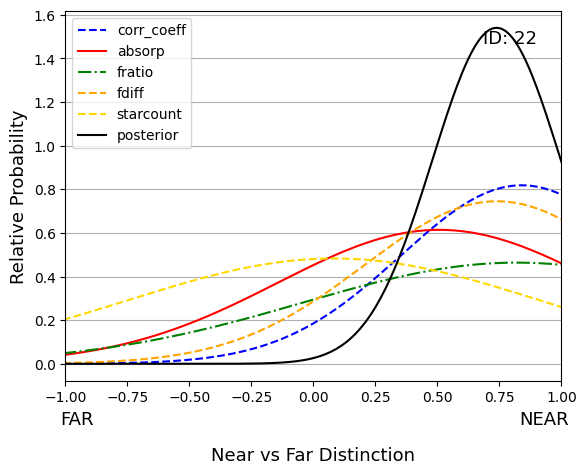

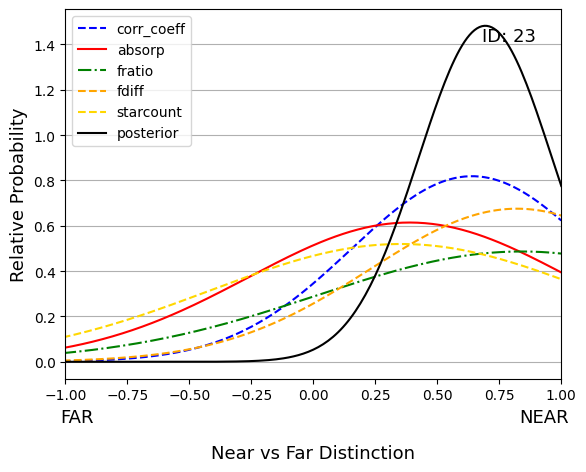

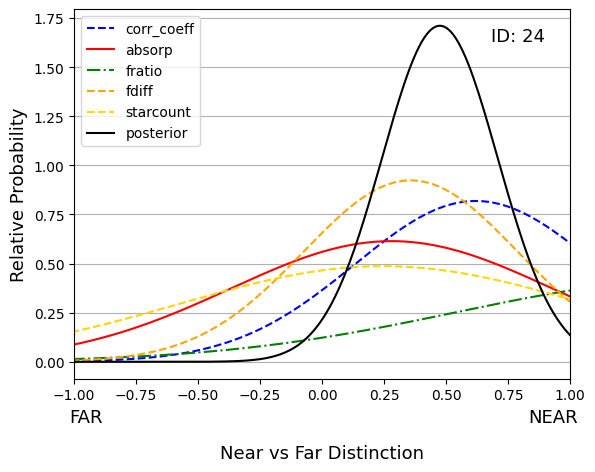

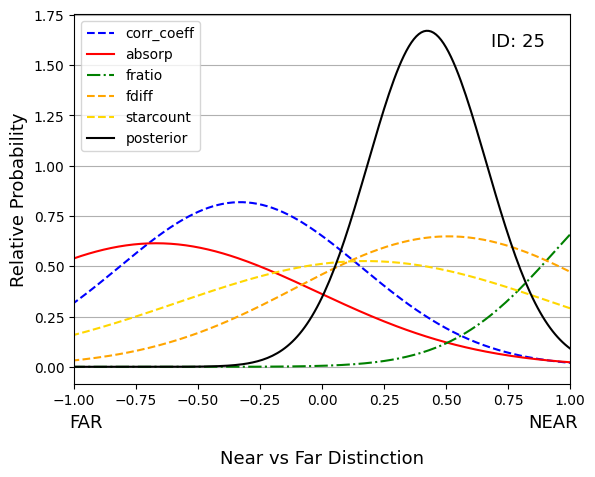

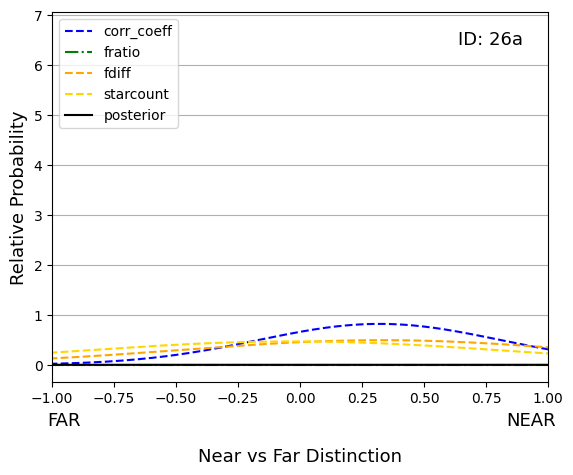

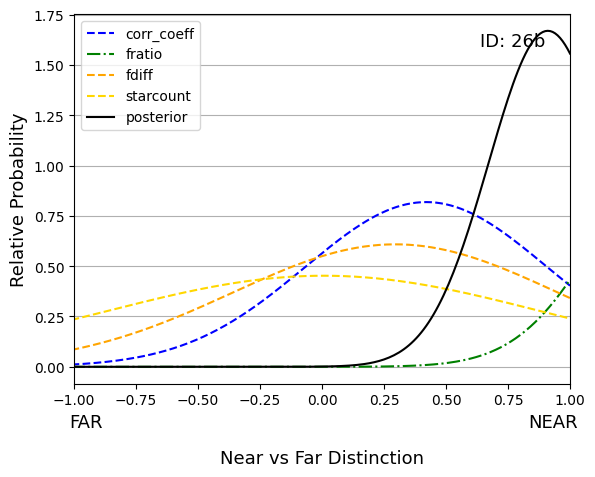

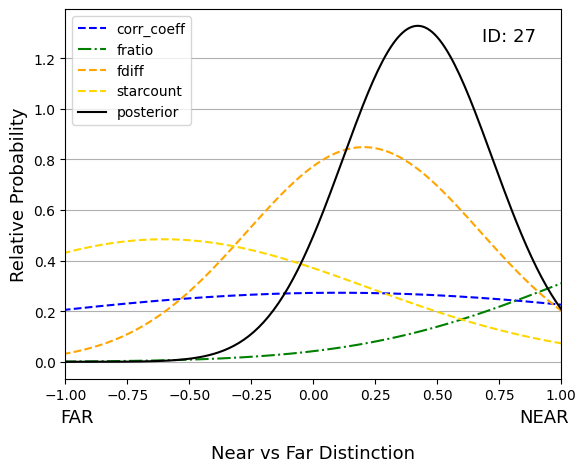

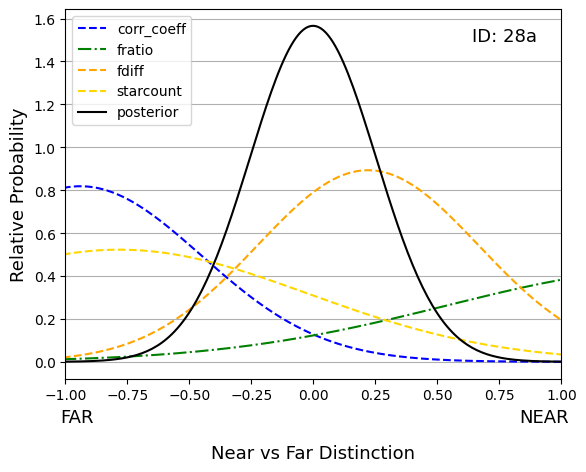

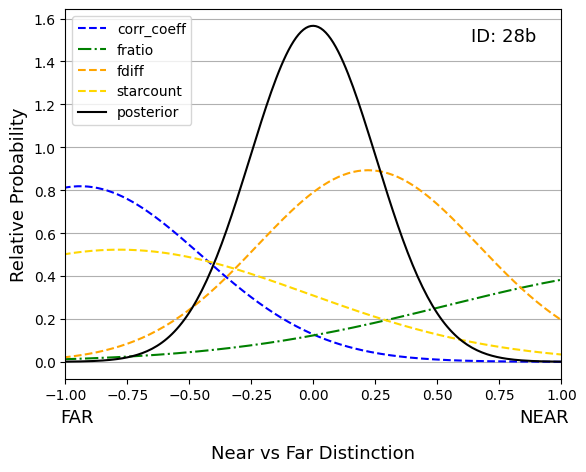

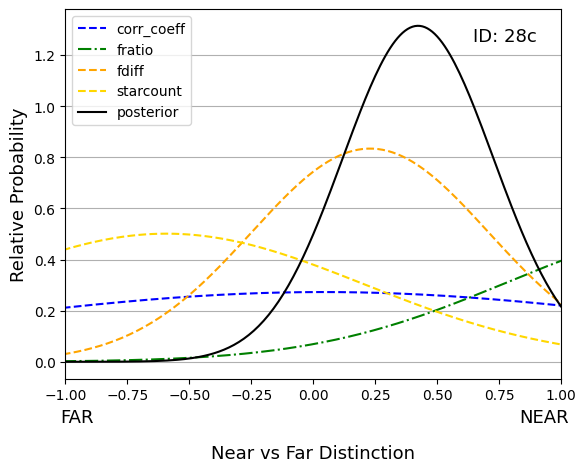

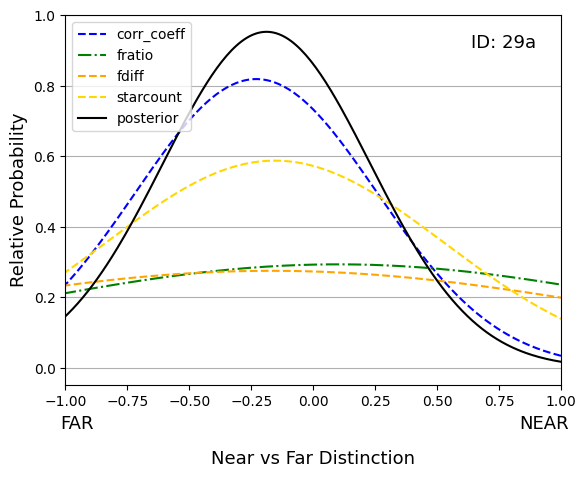

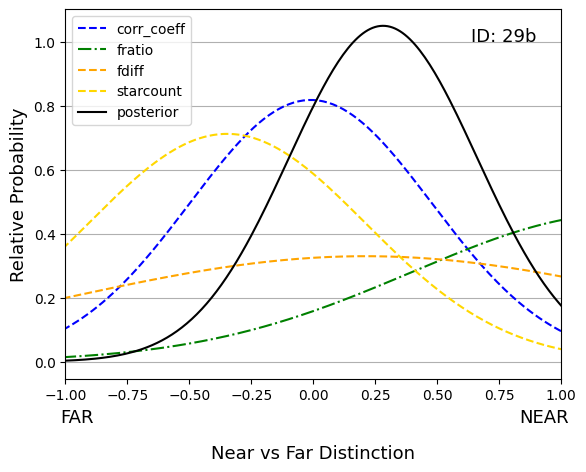

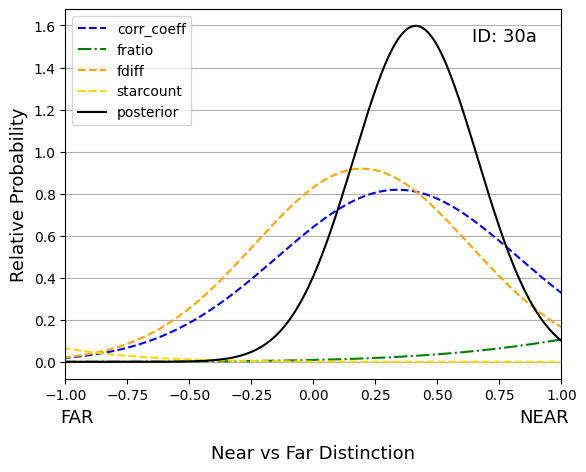

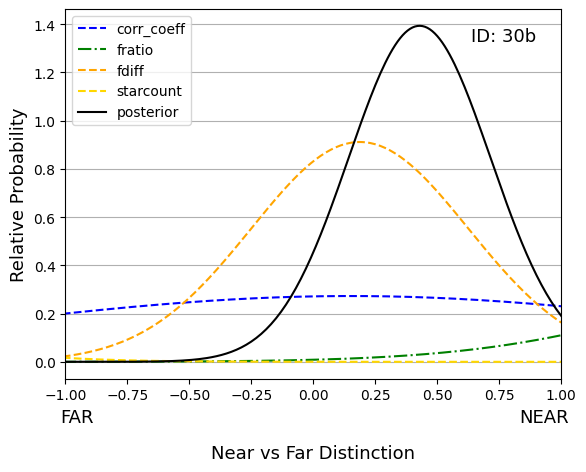

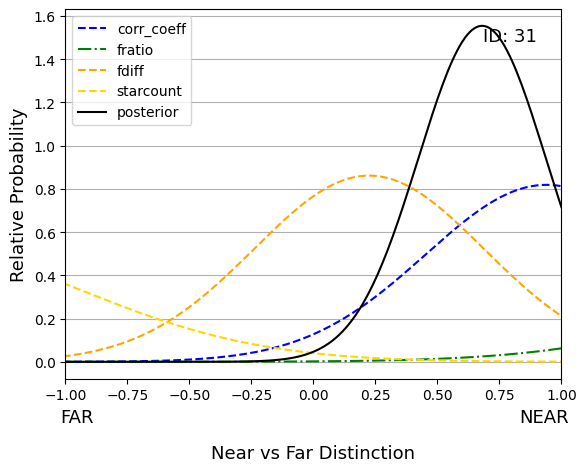

In [85]:
post_tab = Table()
A, mu, sigma, cloudid = [], [], [], []

for i in cat_index:
    cat_id = np.where(cat_index == i)[0][0]
        
    pdfvec=ppdf(i)

    plot_pdf(i, pdfvec)
    if ~np.isnan(pdfvec.posterior).any() == True:
        parameters, covariance =curve_fit(gaussian, x, pdfvec.posterior, 
                                          p0 = [1, np.nanmean(pdfvec.posterior),np.std(pdfvec.posterior)])
        A.append(parameters[0])
        mu.append(parameters[1])
        sigma.append(parameters[2])
        cloudid.append(i)
    else:
        A.append(np.nan)
        mu.append(np.nan)
        sigma.append(np.nan)
        cloudid.append(i)

post_tab['cloud_id'] = cloudid
post_tab['A'] = A
post_tab['mu'] = mu
post_tab['sigma'] = sigma

    
post_tab.write("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex", overwrite=True)



In [87]:
post_tab[10:20]

cloud_id,A,mu,sigma
str3,float64,float64,float64
8a,1.3776610417999369,-0.16533403203036007,0.28957941634192397
8b,2.6481483672569084e-11,0.0250000000030954,0.1410772008582183
8c,-0.0056059698771023965,0.3350630961261793,-0.00040722397916753065
9,1.3345174744709565,0.24944695939114675,0.2989412188548416
10,5.038837030066585,0.08504093626835497,0.07917348348854236
11a,1.2932371277684465,-0.5679862913420801,0.3084834728568534
11b,1.2949076073213723,-0.6250379728566375,0.30808551756575053
11c,1.3315124839749495,-0.6391294842878127,0.2996158768338955
12,1.3226841370925617,-0.7428797725558889,-0.3016156837552779


In [82]:
mu[18]

1.3226841370925617

In [83]:
cat_index[18]

'12'